# Sampling Raster Data with XArray

## Introduction

Many scientific and environmental datasets come as gridded rasters. If you want to know the value of a variable at a single or multiple locations, you can use sampling techniques to extract the values. XArray has powerful indexing methods that allow us to extract values at multiple coordinates easily.

## Overview of the Task

In this tutorial, we will take a raster file of temperature anomalies and a CSV file with locations of all urban areas in the US. We will use Pandas and Xarray to find the temperature anomaly in all the urban areas and find the top 10 areas experiencing the highest anomaly. We will also use GeoPandas to save the results as a vector layer.

**Input Layers**:
* `t.anom.202207.tif`: Raster grid of temprature anomaly for the month of July 2022 in the US.
*  `2021_Gaz_ua_national.zip`: A CSV file with point locations representing urban areas in the US.

**Output Layers**:
*   `tanomaly.gpkg` : A GeoPackage containing a vector layer of point locations with anomaly values sampled from the raster.


**Data Credit**:
*   [US July 2021 Temperature Anomaly](https://www.cpc.ncep.noaa.gov/products/GIS/GIS_DATA/). NOAA Climate Prediction Center. Retrieved 2022-09
*   [US Gazetteer files: 2021](https://www.census.gov/geographies/reference-files/time-series/geo/gazetteer-files.2021.html) United States Census Bureau. Retrieved 2022-09.


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install rioxarray

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import rioxarray as rxr
import rasterio as rio
import matplotlib.pyplot as plt

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

raster_file = 't.anom.202207.tif'
csv_file = '2021_Gaz_ua_national.zip'

data_url = 'https://github.com/spatialthoughts/geopython-tutorials/releases/download/data/'

download(data_url + raster_file)
download(data_url + csv_file)

Downloaded data/t.anom.202207.tif
Downloaded data/2021_Gaz_ua_national.zip


## Data Pre-Processing

First we read the raster file using `rioxarray`

In [ ]:
raster_filepath = os.path.join(data_folder, raster_file)
raster = rxr.open_rasterio(raster_filepath, mask_and_scale=True)
raster

<xarray.DataArray (band: 1, y: 32, x: 64)> Size: 8kB
[2048 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 512B -130.0 -129.0 -128.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 256B 52.0 51.0 50.0 49.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        GrADS version 2.0.2 
    TIFFTAG_XRESOLUTION:     0.171875
    TIFFTAG_YRESOLUTION:     0.265625
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area

Let's Look at some pixel values.

In [ ]:
raster.values

array([[[-9.99e+08, -9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08,
         -9.99e+08],
        [-9.99e+08, -9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08,
         -9.99e+08],
        [-9.99e+08, -9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08,
         -9.99e+08],
        ...,
        [-9.99e+08, -9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08,
         -9.99e+08],
        [-9.99e+08, -9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08,
         -9.99e+08],
        [-9.99e+08, -9.99e+08, -9.99e+08, ..., -9.99e+08, -9.99e+08,
         -9.99e+08]]], dtype=float32)

You will notice that the raster has many pixels with value -9.99e+08. These are NoData values. One option is to mask these values to get only the valid pixels which will set them to `nan` values. But the `nan` values result in missing values at the edges when we interpolate or resample the data. In this case, we can set the missing anomaly values to 0.

In [ ]:
nodata = -999000000
raster_filled = raster.where(raster != nodata, 0)
raster_filled

<xarray.DataArray (band: 1, y: 32, x: 64)> Size: 8kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 512B -130.0 -129.0 -128.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 256B 52.0 51.0 50.0 49.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        GrADS version 2.0.2 
    TIFFTAG_XRESOLUTION:     0.171875
    TIFFTAG_YRESOLUTION:     0.265625
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area

The raster has only 1 band containing temperature anomaly values, so we select it.

In [ ]:
tanomaly = raster_filled.sel(band=1)
tanomaly

<xarray.DataArray (y: 32, x: 64)> Size: 8kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 512B -130.0 -129.0 -128.0 ... -69.0 -68.0 -67.0
  * y            (y) float64 256B 52.0 51.0 50.0 49.0 ... 24.0 23.0 22.0 21.0
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_SOFTWARE:        GrADS version 2.0.2 
    TIFFTAG_XRESOLUTION:     0.171875
    TIFFTAG_YRESOLUTION:     0.265625
    TIFFTAG_RESOLUTIONUNIT:  2 (pixels/inch)
    AREA_OR_POINT:           Area

Let's plot the data. It shows high temperature anomaly in the north-west US due to a [record-breaking heatwave](https://phys.org/news/2022-05-hidden-backstory-deadly-pacific-northwest.html).

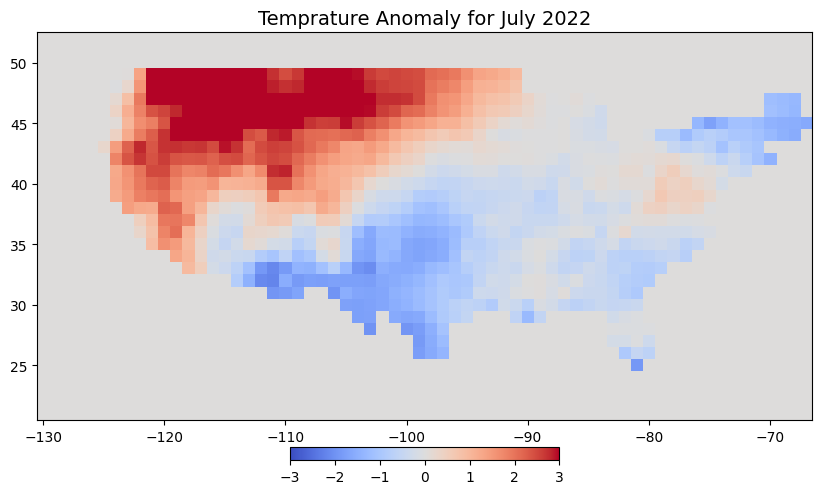

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

tanomaly.plot.imshow(
    ax=ax, vmin=-3, vmax=3, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)

ax.set_title('Temprature Anomaly for July 2022', fontsize = 14)
ax.set_aspect('equal')
plt.show()

Next, we read the Zipped CSV file containing the urban areas. This is a plain-text file with tab separated values. The column names also contain trailing whitespaces, so we remove them as well.

In [ ]:
csv_filepath = os.path.join(data_folder, csv_file)
df  = pd.read_csv(csv_filepath, delimiter = '\t', compression='zip')
df.columns = df.columns.str.replace(' ', '')
df

,GEOID,NAME,UATYPE,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,INTPTLAT,INTPTLONG
0,37,"Abbeville, LA Urban Cluster",C,29189598,298416,11.270,0.115,29.967156,-92.095966
1,64,"Abbeville, SC Urban Cluster",C,11271136,19786,4.352,0.008,34.179273,-82.379776
2,91,"Abbotsford, WI Urban Cluster",C,5426584,13221,2.095,0.005,44.948612,-90.315875
3,118,"Aberdeen, MS Urban Cluster",C,7416338,52820,2.863,0.020,33.824742,-88.554591
4,145,"Aberdeen, SD Urban Cluster",C,33032902,120864,12.754,0.047,45.463186,-98.471033
...,...,...,...,...,...,...,...,...,...
3596,98101,"Zapata--Medina, TX Urban Cluster",C,13451264,0,5.194,0.000,26.889081,-99.266192
3597,98182,"Zephyrhills, FL Urbanized Area",U,112593840,1615599,43.473,0.624,28.285373,-82.198969
3598,98209,"Zimmerman, MN Urban Cluster",C,24456008,2495147,9.443,0.963,45.455850,-93.606705
3599,98236,"Zumbrota, MN Urban Cluster",C,4829469,0,1.865,0.000,44.292793,-92.670931


Since we have the coordinates of each urban center in the *INTPTLAT* and *INTPTLONG* columns, we can convert this dataframe to a GeoDataFrame.

In [ ]:
geometry = gpd.points_from_xy(df.INTPTLONG, df.INTPTLAT)
gdf = gpd.GeoDataFrame(df, crs='EPSG:4326', geometry=geometry)
gdf

Let's visualize the points along with the raster. As the GeoDataFrame contains points outside the continental US, we limit our plot to the bounds of the `tanomaly` layer.

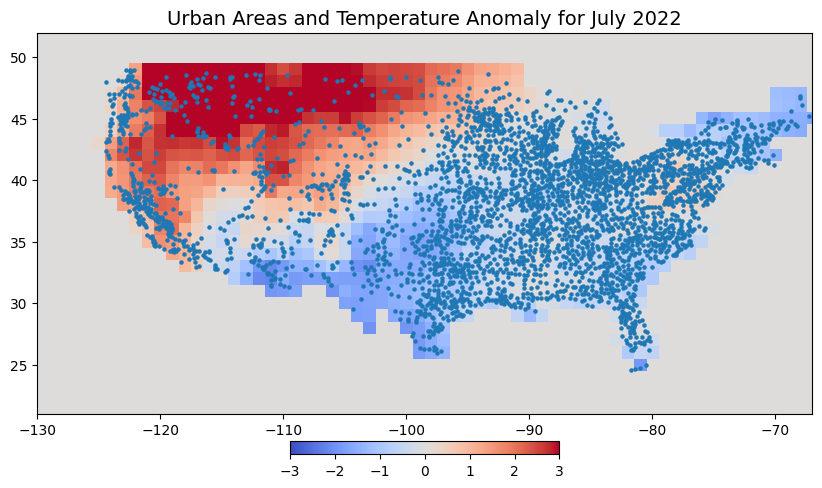

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

tanomaly.plot.imshow(
    ax=ax, vmin=-3, vmax=3, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)
gdf.plot(ax=ax, markersize=5)
ax.set_xlim([tanomaly.x.min(), tanomaly.x.max()])
ax.set_ylim([tanomaly.y.min(), tanomaly.y.max()])
ax.set_title('Urban Areas and Temperature Anomaly for July 2022', fontsize = 14)
ax.set_aspect('equal')

plt.show()

## Resampling Data

Climate data is often low resolution and for sampling point values, it makes sense to resample this to a finer resolution by applying a `bilinear` or `cubic` interpolation. This will ensure that when we sample the data at any point, we will get a representative value based on neighboring observations.

We will use `rioxarray` for [resampling](https://corteva.github.io/rioxarray/stable/examples/resampling.html) the raster data.

In [ ]:
upscale_factor = 4
resampling_method = rio.enums.Resampling.cubic

new_width = tanomaly.rio.width * upscale_factor
new_height = tanomaly.rio.height * upscale_factor

tanomaly_resampled = tanomaly.rio.reproject(
    tanomaly.rio.crs,
    shape=(new_height, new_width),
    resampling=resampling_method,
)

tanomaly_resampled

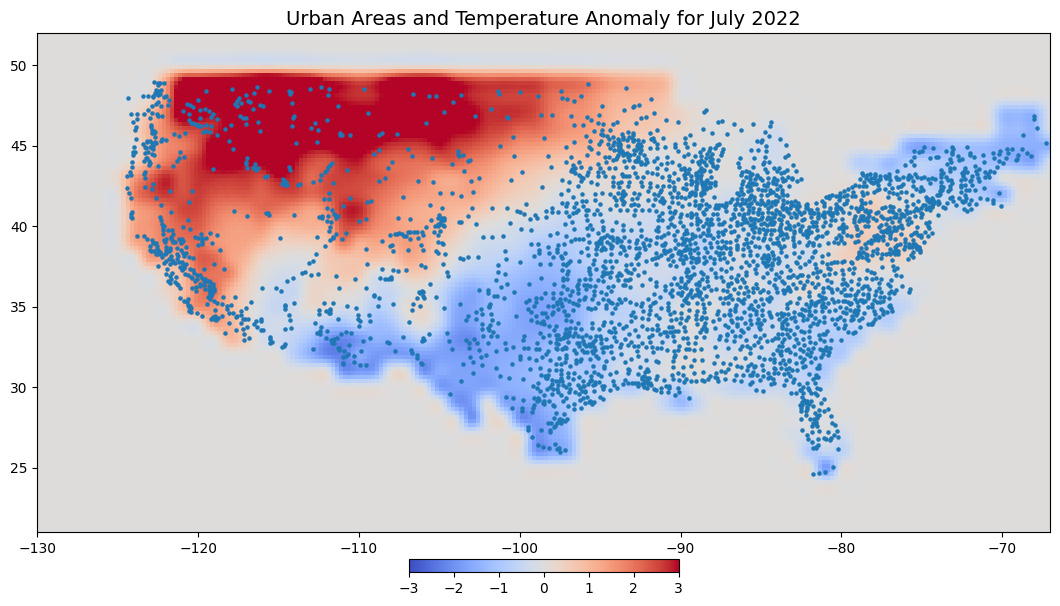

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15, 7)

cbar_kwargs = {
    'orientation':'horizontal',
    'fraction': 0.025,
    'pad': 0.05,
    'extend':'neither'
}

tanomaly_resampled.plot.imshow(
    ax=ax, vmin=-3, vmax=3, add_labels=False,
    cmap='coolwarm', cbar_kwargs=cbar_kwargs)

gdf.plot(ax=ax, markersize=5)
ax.set_xlim([tanomaly.x.min(), tanomaly.x.max()])
ax.set_ylim([tanomaly.y.min(), tanomaly.y.max()])
ax.set_title('Urban Areas and Temperature Anomaly for July 2022', fontsize = 14)
ax.set_aspect('equal')

plt.show()

## Sampling Raster Values

Now we will extract the value of the raster pixels at each urban area point. Xarray's `sel()` method allows you to specify coordinates at multiple dimentions to extract the array value.

We have our coordinates in a GeoDataFrame, we can use Panda's `to_xarray()` method to convert the X and Y coordinates to a DataArray. When we use this to select the pixels from the raster array, the resulting DataArray being reindexed by the GeoDataFrame's index.This will allow us to merge the results easily to the original GeoDataFrame.

In [ ]:
x_coords = gdf.geometry.x.to_xarray()
y_coords = gdf.geometry.y.to_xarray()

Now we sample the values at these coordinates. Note that since the raster data pixels will not be indexed at the exact X and Y coordinates, we use `method=nearest` to pick the closest pixel.

In [ ]:
sampled = tanomaly_resampled.sel(x=x_coords, y=y_coords, method='nearest')

To convert the resulting DataArray to Pandas, we use `to_series()` method.

In [ ]:
gdf['tanomaly'] = sampled.to_series()
gdf.iloc[:, -5:]

,AWATER_SQMI,INTPTLAT,INTPTLONG,geometry,tanomaly
0,0.115,29.967156,-92.095966,POINT (-92.09597 29.96716),-0.272462
1,0.008,34.179273,-82.379776,POINT (-82.37978 34.17927),-0.704404
2,0.005,44.948612,-90.315875,POINT (-90.31588 44.94861),0.130515
3,0.020,33.824742,-88.554591,POINT (-88.55459 33.82474),0.018811
4,0.047,45.463186,-98.471033,POINT (-98.47103 45.46319),1.311932
...,...,...,...,...,...
3596,0.000,26.889081,-99.266192,POINT (-99.26619 26.88908),-1.866690
3597,0.624,28.285373,-82.198969,POINT (-82.19897 28.28537),-0.064647
3598,0.963,45.455850,-93.606705,POINT (-93.6067 45.45585),0.607703
3599,0.000,44.292793,-92.670931,POINT (-92.67093 44.29279),0.007632


Now that we have the anomaly at each point location, let's sort and find out the Top10 locations with highest anomaly.

In [ ]:
sorted_gdf = gdf.sort_values(by=['tanomaly'], ascending=False)
top10 = sorted_gdf.iloc[:10].reset_index()
top10[['NAME', 'tanomaly']]

,NAME,tanomaly
0,"Osburn, ID Urban Cluster",5.214408
1,"Kellogg, ID Urban Cluster",4.543093
2,"Libby, MT Urban Cluster",4.543093
3,"Bonners Ferry, ID Urban Cluster",4.487802
4,"Orofino, ID Urban Cluster",4.411723
5,"Grangeville, ID Urban Cluster",4.411723
6,"La Grande, OR Urban Cluster",4.300000
7,"Baker City, OR Urban Cluster",4.300000
8,"Rathdrum, ID Urban Cluster",4.138633
9,"Deer Park, WA Urban Cluster",4.138633


Let's plot them on a map.

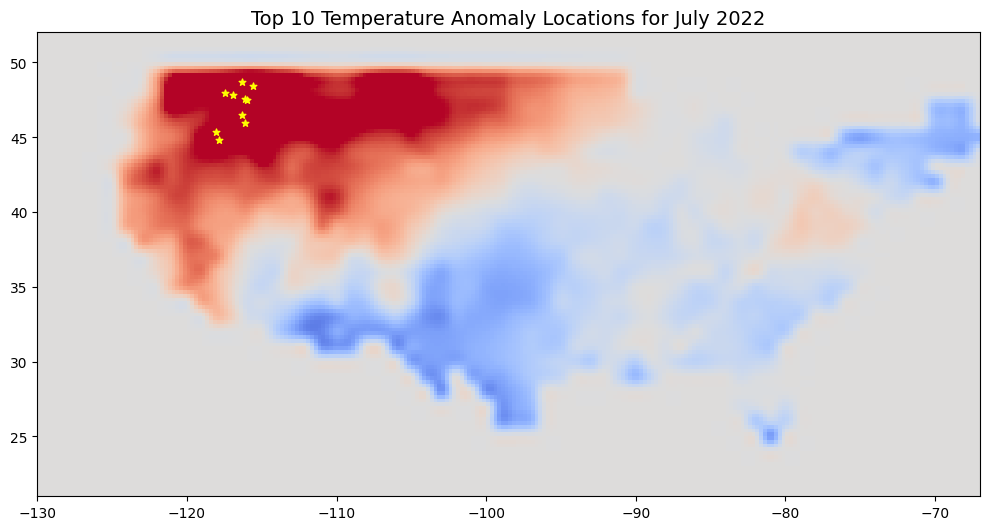

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

tanomaly_resampled.plot.imshow(
    ax=ax, vmin=-3, vmax=3, add_labels=False,
    cmap='coolwarm', add_colorbar=False)

top10.plot(ax=ax, markersize=25, color='yellow', marker='*')
ax.set_xlim([tanomaly.x.min(), tanomaly.x.max()])
ax.set_ylim([tanomaly.y.min(), tanomaly.y.max()])
ax.set_title('Top 10 Temperature Anomaly Locations for July 2022', fontsize = 14)

ax.set_aspect('equal')
plt.tight_layout()
plt.show()

Finally, we save the sampled result to disk as `.gpkg`.

In [ ]:
output_filename = 'tanomaly.gpkg'
output_path = os.path.join(output_folder, output_filename)

gdf.to_file(driver='GPKG', filename=output_path)

----

If you want to give feedback or share your experience with this tutorial, please comment below. (requires GitHub account)


<script src='https://utteranc.es/client.js'
    repo='spatialthoughts/geopython-tutorials'
    issue-term='pathname'
    theme='github-light'
    crossorigin='anonymous'
    async>
</script>